0 files missing from root.txt in C:\Users\fedor\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\fedor\mne_data\MNE-fsaverage-data\fsaverage
Loading MEG data...
Opening raw data file C:\Users\fedor\Documents\EEG programs\EEG DATA SETS\MY_DATA\S035_rest_run1_raw_tsss_mc_trans.fif...
    Range : 71000 ... 677999 =     71.000 ...   677.999 secs
Ready.


C:\Users\fedor\AppData\Local\Temp\ipykernel_28520\795011836.py:20: RuntimeWarning: This filename (C:\Users\fedor\Documents\EEG programs\EEG DATA SETS\MY_DATA\S035_rest_run1_raw_tsss_mc_trans.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(meg_file, preload=True)


Reading 0 ... 606999  =      0.000 ...   606.999 secs...
Preprocessing data...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 330001 samples (330.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   13.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   24.4s


2 events found on stim channel STI101
Event IDs: [1 2]
2 events found on stim channel STI101
Event IDs: [1 2]
Creating epochs...
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 1000 original time points ...
0 bad epochs dropped
Created 60 epochs
Computing noise covariance matrix...
Using up to 3035 segments
Number of samples used : 60700
[done]
Setting up source space...
Setting up the source space with the following parameters:

SUBJECTS_DIR = C:\Users\fedor\mne_data\MNE-fsaverage-data
Subject      = fsaverage
Surface      = white
Octahedron subdivision grade 5

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading C:\Users\fedor\mne_data\MNE-fsaverage-data\fsaverage\surf\lh.white...
Mapping lh fsaverage -> oct (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\fedor\mne_data\MNE-fsaverage-data\fsaverage\surf\lh.sphere

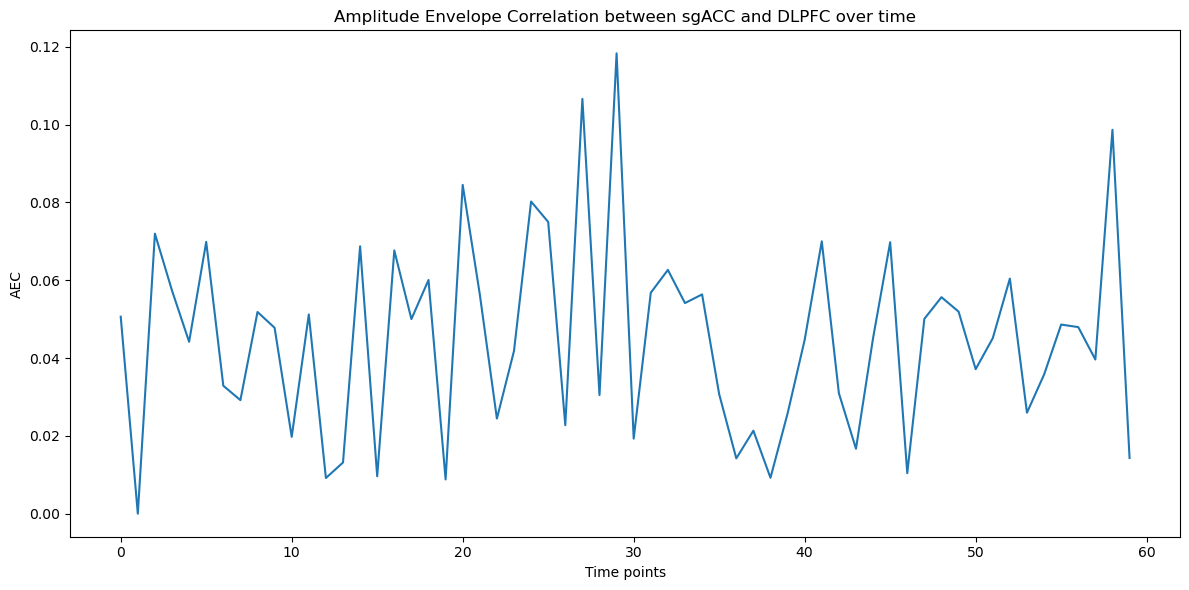

Visualizing 3D connection...
sgACC_center: [-0.00682243  0.03389063  0.00163523]
DLPFC_center: [-0.03133031  0.04118181  0.01653212]
Shape of coords: (2, 3)
Shape of conn_matrix: (2, 2)
Shape of coords: (2, 3)


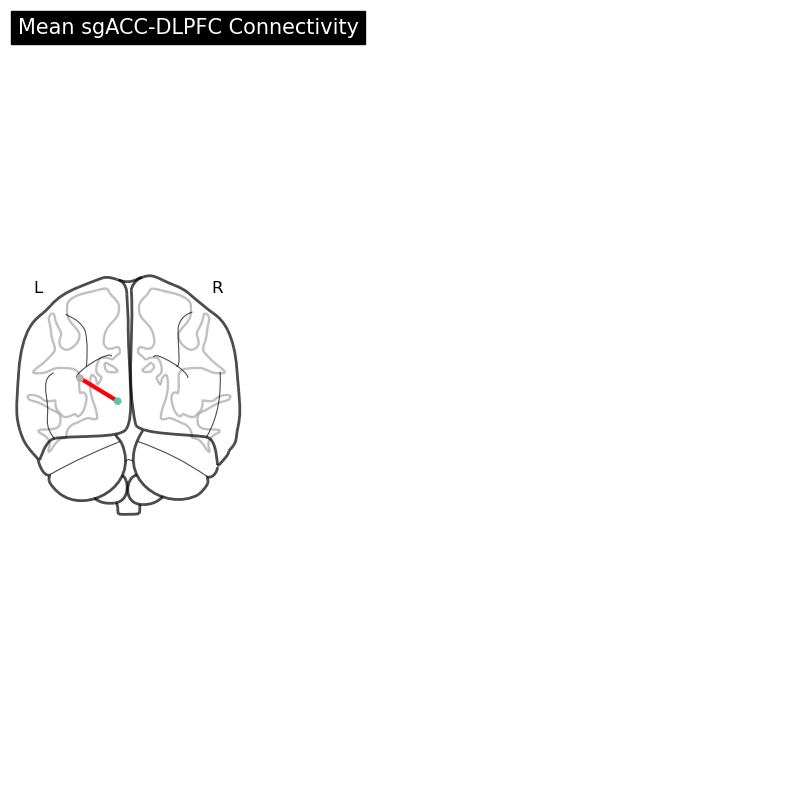

3D visualization completed and saved.
Script completed!


In [1]:
%matplotlib inline
import os
import numpy as np
import mne
from mne.minimum_norm import make_inverse_operator, apply_inverse_epochs
from mne_connectivity import envelope_correlation
import matplotlib.pyplot as plt
from nilearn import plotting
from tqdm.notebook import tqdm

# File paths
meg_file = r'C:\Users\fedor\Documents\ yourdata.fif'

# Fetch fsaverage files
fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

# Load MEG data
print("Loading MEG data...")
raw = mne.io.read_raw_fif(meg_file, preload=True)

# Preprocess the data
print("Preprocessing data...")
raw.filter(l_freq=0.01, h_freq=100)  # Filter between 0.01-100 Hz
raw.resample(sfreq=100)  # Downsample to 100 Hz

# Create epochs
print("Creating epochs...")
epochs = mne.make_fixed_length_epochs(raw, duration=10, preload=True)  # 10-second epochs

print(f"Created {len(epochs)} epochs")

# Compute noise covariance matrix
print("Computing noise covariance matrix...")
noise_cov = mne.compute_raw_covariance(raw, tmin=0, tmax=None)

# Setup source space
print("Setting up source space...")
src = mne.setup_source_space('fsaverage', spacing='oct5', add_dist=False, subjects_dir=subjects_dir)

# Compute or load the head -> MRI transform
print("Computing head -> MRI transform...")
try:
    trans = mne.compute_raw_coregistration(raw, subject='fsaverage', subjects_dir=subjects_dir)
    print("Successfully computed the transformation.")
except Exception as e:
    print(f"Could not compute transformation: {e}")
    print("Using identity transformation as a fallback.")
    trans = 'fsaverage'  # This will use an identity transform

# Compute forward solution
print("Computing forward solution...")
conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(subject='fsaverage', ico=4, conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

fwd = mne.make_forward_solution(epochs.info, trans=trans, src=src, bem=bem,
                                meg=True, eeg=False, mindist=5.0, n_jobs=1)

# Compute inverse operator
print("Computing inverse operator...")
inverse_operator = make_inverse_operator(epochs.info, fwd, noise_cov, loose=0.2, depth=0.8)

# Apply inverse operator to get source estimates
print("Applying inverse operator...")
stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2=1.0 / 9.0, method='dSPM', pick_ori=None, verbose=True)

# Load Desikan-Killiany atlas
print("Loading Desikan-Killiany atlas...")
labels = mne.read_labels_from_annot('fsaverage', parc='aparc', subjects_dir=subjects_dir)

# Find approximate sgACC and DLPFC labels
sgACC = [label for label in labels if 'rostralanteriorcingulate' in label.name.lower() and 'lh' in label.name][0]
DLPFC = [label for label in labels if 'rostralmiddlefrontal' in label.name.lower() and 'lh' in label.name][0]

print(f"Using {sgACC.name} as sgACC")
print(f"Using {DLPFC.name} as DLPFC")

# Extract time series from ROIs
print("Extracting time series from ROIs...")
sgACC_ts = mne.extract_label_time_course(stcs, sgACC, src, mode='mean')
DLPFC_ts = mne.extract_label_time_course(stcs, DLPFC, src, mode='mean')

# Reshape the time series into epochs
n_epochs = len(sgACC_ts)
n_times = sgACC_ts[0].shape[1]
sgACC_ts_reshaped = np.array(sgACC_ts).reshape(n_epochs, n_times)
DLPFC_ts_reshaped = np.array(DLPFC_ts).reshape(n_epochs, n_times)

# Combine the time series
combined_ts = np.array([sgACC_ts_reshaped, DLPFC_ts_reshaped])

# Compute AEC
print("Computing AEC...")
aec = envelope_correlation(combined_ts)

# Extract the connectivity data
conn_data = aec.get_data()

# Print the shape and type of conn_data
print(f"Shape of conn_data: {conn_data.shape}")
print(f"Type of conn_data: {type(conn_data)}")
print(f"Type of elements in conn_data: {type(conn_data[0, 0, 0, 0])}")

# Extract the connectivity between sgACC and DLPFC
sgACC_DLPFC_conn = conn_data[0, 1, :, 0]  # Connectivity from sgACC to DLPFC across time

# Print results
print(f"Mean AEC between sgACC and DLPFC: {np.mean(sgACC_DLPFC_conn)}")

# 2D plot of connectivity over time
print("Creating 2D plot...")
plt.figure(figsize=(12, 6))
plt.plot(sgACC_DLPFC_conn)
plt.title('Amplitude Envelope Correlation between sgACC and DLPFC over time')
plt.xlabel('Time points')
plt.ylabel('AEC')
plt.tight_layout()
plt.savefig('sgACC_DLPFC_connectivity_timeseries.png')
plt.show()

# Visualize the mean connection in 3D
print("Visualizing 3D connection...")

# Get the vertex coordinates for each label
sgACC_vertices = src[0]['rr'][sgACC.vertices]
DLPFC_vertices = src[0]['rr'][DLPFC.vertices]

# Calculate the center of mass for each ROI
sgACC_center = np.mean(sgACC_vertices, axis=0)
DLPFC_center = np.mean(DLPFC_vertices, axis=0)

print(f"sgACC_center: {sgACC_center}")
print(f"DLPFC_center: {DLPFC_center}")

# Ensure coords is a 2D array with shape (2, 3)
coords = np.vstack((sgACC_center, DLPFC_center))

# Print shape of coords for debugging
print(f"Shape of coords: {coords.shape}")

mean_conn = np.mean(sgACC_DLPFC_conn)
conn_matrix = np.array([[0, mean_conn], 
                        [mean_conn, 0]])

# Print shapes for debugging
print(f"Shape of conn_matrix: {conn_matrix.shape}")
print(f"Shape of coords: {coords.shape}")

# Convert coordinates from meters to millimeters
coords_mm = coords * 1000

# Create the 3D plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': '3d'})
plot_connectome = plotting.plot_connectome(
    conn_matrix,
    coords_mm,
    node_size=20, 
    title='Mean sgACC-DLPFC Connectivity',
    figure=fig,
    axes=ax
)

# Save the figure
plt.savefig('sgACC_DLPFC_connectivity_3D.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

print("3D visualization completed and saved.")
print("Script completed!")